# Combine multi-country HLA data
We can calculate the average allele frequency of multiple countries
by combining studies within countries and then between countries.
This second step is very similar except we set `datasetID` as the country
rather than the population, which is the default.

The estimates from different countries can be weighted by sample size or another supplied variable such as population size. Both are described below.

In [1]:
import HLAfreq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Download HLA data for each specified country

In [2]:
countries = ['Cameroon','Cape+Verde','Ghana','Guinea',
    'Guinea-Bissau', 'Kenya','Sao+Tome+and+Principe','Senegal',
    'South+Africa','Uganda','Zimbabwe']


In [3]:

for country in countries:
    print(country)
    base_url = HLAfreq.makeURL(
        country, standard='s', locus="A",
        resolution_pattern="bigger_equal_than", resolution=2)
    aftab = HLAfreq.getAFdata(base_url)
    aftab.to_csv("../data/example/multi_country/%s_raw.csv" %country, index=False)


Cameroon
2 pages of results
Download complete
Cape+Verde
1 pages of results
Download complete
Ghana
1 pages of results
Download complete
Guinea
3 pages of results
Download complete
Guinea-Bissau
2 pages of results
Download complete
Kenya
2 pages of results
Download complete
Sao+Tome+and+Principe
1 pages of results
Download complete
Senegal
1 pages of results
Download complete
South+Africa
3 pages of results
Download complete
Uganda
1 pages of results
Download complete
Zimbabwe
1 pages of results
Download complete


## Combine allele frequencies within country

In [4]:
cafs = []
for country in countries:
    # Load raw county data
    aftab = pd.read_csv("../data/example/multi_country/%s_raw.csv" %country)
    # Drop any incomplete studies
    aftab = HLAfreq.only_complete(aftab)
    # Ensure all alleles have the same resolution
    aftab = HLAfreq.decrease_resolution(aftab, 2)
    # Combine studies within country
    caf = HLAfreq.combineAF(aftab)
    # Add country name to dataset, this is used as `datasetID` going forward
    caf['country'] = country
    cafs.append(caf)


population               loci
South Africa Natal Zulu  A       0.935
Name: allele_freq, dtype: float64
1 studies have total allele frequency < 0.95


## Combine all country data
Concatenate each single county dataset into a single multicountry dataset.
Combine allele frequencies, using the manually added `country` column as `datasetID`.

In [5]:
cafs = pd.concat(cafs, ignore_index=True)
international = HLAfreq.combineAF(cafs, datasetID='country')

# View allele frequencies
Plot allele frequencies averaged across countries.
Filter to only alleles with >1% frequency after averaging.

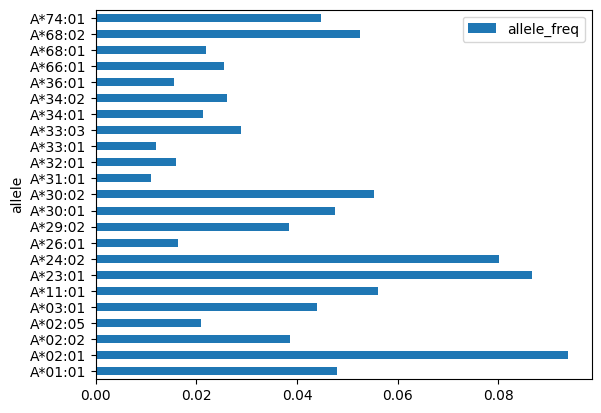

In [6]:
# Plot international averages as bar plot
mask = international.allele_freq > 0.01
international[mask].plot.barh('allele', 'allele_freq')
plt.show()

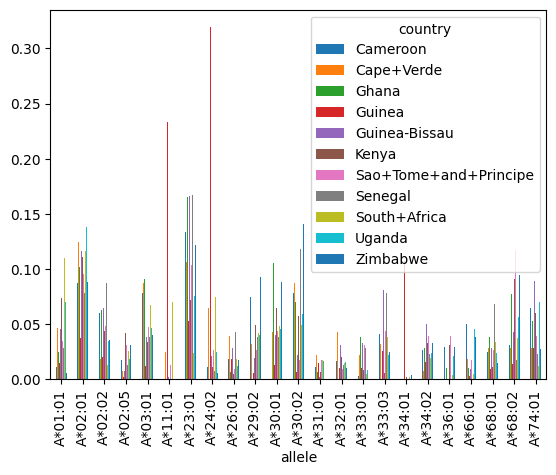

In [7]:
mask2 = cafs.allele.isin(international.allele[mask])
# Plot national averages as grouped bar plot
cafs[mask2].pivot(index='allele', columns='country', values='allele_freq').plot.bar()
plt.show()

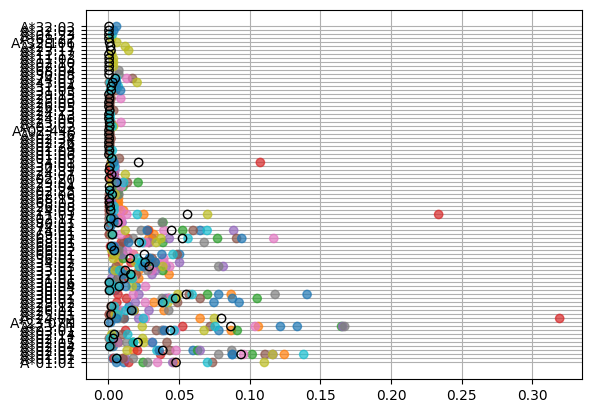

In [10]:
# Plot international allele frequencies estimates and individual countries
# Without filtering
HLAfreq.plotAF(international, cafs, datasetID='country')

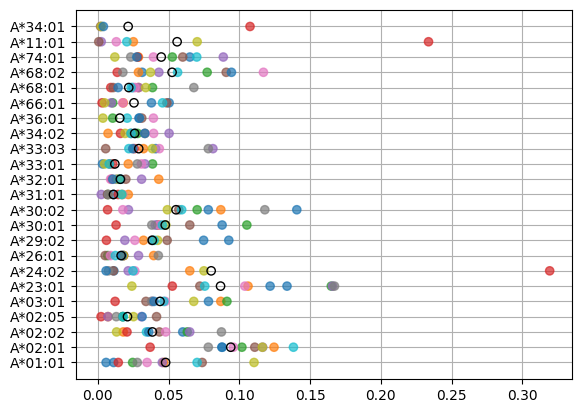

In [14]:
# Plot specific alleles and zoom in on frequencies
# Select alleles to plot
hifreq = international[international.allele_freq > 0.01].allele
# Must be a list
hifreq = hifreq.tolist()
# Plot only selected alleles
HLAfreq.plotAF(
    international[international.allele.isin(hifreq)],
    cafs[cafs.allele.isin(hifreq)],
    datasetID='country')

From these plots we can clearly see that one country has much
higher frequencies of A\*24:02, A\*11:01, and A\*34:01.
It is also clear that the international average allele
frequency for A\*24:02 is being skewed by this country. We can view the
`cafs` dataset to see which country this is, Guinea.

This method can
also be applied to individual countries to identify studies which
differ from the majority, possibly because it focuses on a specific
ethnic group.

In [15]:
cafs[cafs.allele == "A*24:02"].sort_values('allele_freq')

,allele,loci,wav,c,sample_size,alpha,allele_freq,country
383,A*24:02,A,0.004000,1.8400,230,1,0.005818,Zimbabwe
262,A*24:02,A,0.005000,1.6500,165,1,0.007458,Senegal
183,A*24:02,A,0.010700,16.0280,749,1,0.010936,Kenya
11,A*24:02,A,0.010322,5.9660,289,1,0.011301,Cameroon
136,A*24:02,A,0.020740,7.9640,192,1,0.021445,Guinea-Bissau
342,A*24:02,A,0.025292,16.9960,336,1,0.024831,Uganda
231,A*24:02,A,0.025449,4.9880,98,1,0.026148,Sao+Tome+and+Principe
45,A*24:02,A,0.068500,16.9880,124,1,0.064939,Cape+Verde
297,A*24:02,A,0.077965,61.5924,395,1,0.074961,South+Africa
99,A*24:02,A,0.327856,419.6560,640,1,0.319246,Guinea


## Weighting countries by population size
When combining allele frequencies across studies, larger studies are given more weight. This is handled by the `weights` parameter. (Specifically the `weights` is multiplied by the allele frequency to calculate the "concentration" of the Dirichlet distribution before adding the prior). By default `weights` is double the sample size as two alleles are measured for person sampled due to diploidy. However, alternative `weights` can be specified. The interpretation of the column used for `weights` is that $n$
samples were observed with allele $x$.

If estimating allele frequency for a region, it may be important to
account for the size of national populations. Below we calculate an
individual weight for each country. A county's populaion, as a proportion
of the sum of countries' populations, multiplied by the number of countries is
used as the weight for each individual in that country. This means that
individuals from large countries contibute more to the total sample but the total sample size is unchanged. Therefore, the uncertainty of estimates is still determined by the overall samplesize.

In [16]:
population_sizes = {'Cameroon':24348251,
    'Cape+Verde':563198,
    'Ghana':30832019,
    'Guinea':12907395,
    'Guinea-Bissau':1646077,
    'Kenya':47564296,
    'Sao+Tome+and+Principe':214610,
    'Senegal':17223497,
    'South+Africa':60604992,
    'Uganda':42885900,
    'Zimbabwe':15178979
}

country_data = pd.DataFrame(
    {'country':population_sizes.keys(),
    'population':population_sizes.values()}
)

# What proportion of the regional population does each country account for
country_data['proportion'] = country_data.population/country_data.population.sum()
# How much will each individual in the country count towards the sample size?
country_data['individual_weight'] = country_data['proportion'] * len(country_data.country)


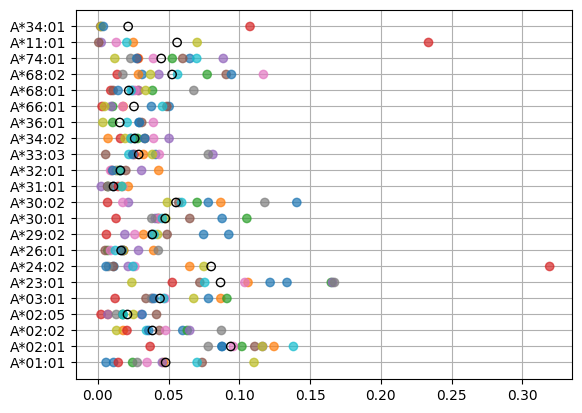

In [17]:
# Add country data to Combined Allele Frequency data
cafs = pd.merge(cafs, country_data, how="left", on='country')
# Sample size is multiplied by this individual weight and doubled
# this accounts for diploid samples from each individual
cafs['weighted_sample_size'] = cafs.sample_size * 2 * cafs.individual_weight

# Calculate allele frequency, weighting each country by the column weighted_sample_szie
winternational = HLAfreq.combineAF(cafs, datasetID='country', weights='weighted_sample_size')

hifreq = winternational[winternational.allele_freq > 0.01].allele
# Must be a list
hifreq = hifreq.tolist()
# Plot only selected alleles
HLAfreq.plotAF(
    international[international.allele.isin(hifreq)],
    cafs[cafs.allele.isin(hifreq)],
    datasetID='country')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Fitting model with PyMc, make take a few seconds


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


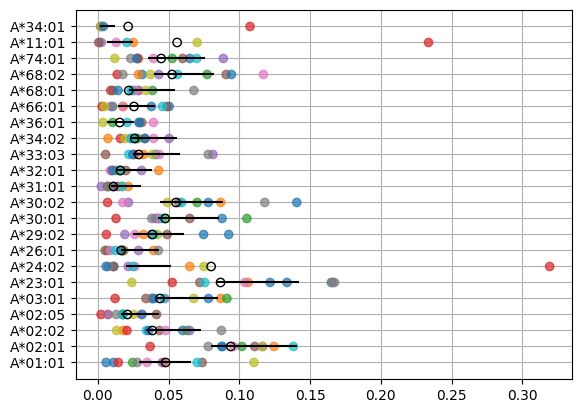

In [18]:
HLAfreq.plotAF(
    international[international.allele.isin(hifreq)],
    cafs[cafs.allele.isin(hifreq)],
    datasetID='country',
    credible_interval=0.95)